In [5]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pylab as plt

from makeCorner import *

az.rcParams["plot.max_subplots"] = 80

In [6]:
cdf_file = "/home/max.lalleman/CBC_Stoch_Search/gwbcbcmodeling/gwbcbcmodeling/New_Code_New_sample/Varying_Peak_sigmoid/cdf_files/CBC_z_0_4.cdf"
# "./RUNS/CBC_O3_Peak.cdf"
data = az.from_netcdf(cdf_file)
samps = data.posterior.stack(draws=("chain", "draw"))

In [7]:
def sigmoid(low, delta, width, middle, zs):
    return delta / (1 + jnp.exp(-(1/width)*(zs - middle))) + low

def sigmoid_no_delta(low, high, width, middle, zs):
    return (high - low) / (1 + jnp.exp(-(1/width)*(zs - middle))) + low

zs = np.linspace(0,4,500)

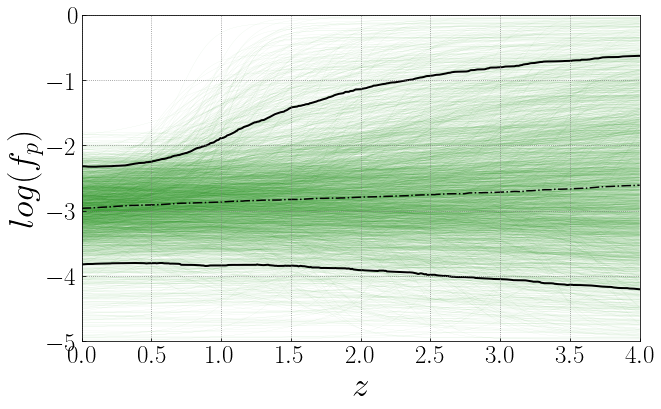

In [10]:
fig,ax = plt.subplots(figsize=(10,6))
ax.set_rasterization_zorder(2)
fp_matrix = np.zeros((len(range(samps.log_f_peak.size)), len(zs)))
for i in range(samps.log_f_peak.size):
    f_peak_r = sigmoid_no_delta(samps.log_f_peak.values[i],
                               samps.log_high_f_peak.values[i],
                               10.**samps.log_width_f_peak.values[i],
                               samps.middle_z_f_peak.values[i],
                               zs,
                              )
    plt.plot(zs, f_peak_r, lw = 0.15, color='#33a02c', alpha = 0.2, zorder = 1)
    fp_matrix[i, :] = f_peak_r

median_fp = np.median(fp_matrix, axis = 0)
plt.xlim(0,4)
plt.ylim(-5, 0)
ax.set_xlabel(r"$z$", fontsize = 35)
ax.set_ylabel(r"$log(f_p)$", fontsize = 35)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.plot(zs, median_fp, "-.", c="k", zorder = 1)
plt.plot(zs,np.quantile(fp_matrix,0.05,axis=0), zorder = 1, color='k', lw=2, alpha=1)
plt.plot(zs,np.quantile(fp_matrix,0.95,axis=0), zorder = 1, color='k', lw=2, alpha=1)
plt.savefig("Trace_f_peak_peak.pdf", dpi=400, bbox_inches='tight')
plt.show()

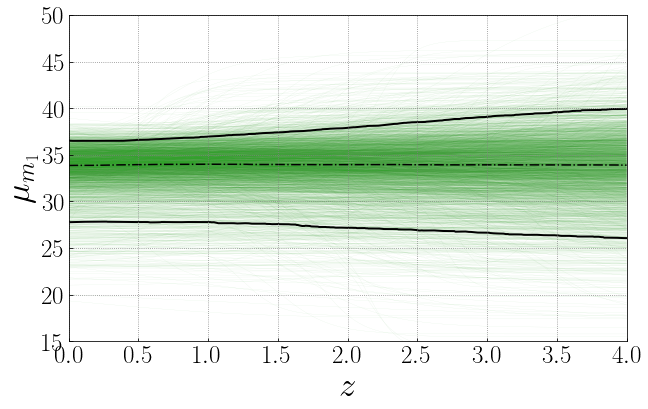

In [11]:
fig,ax = plt.subplots(figsize=(10,6))
ax.set_rasterization_zorder(2)
mu_matrix = np.zeros((len(range(samps.mu_m1.size)), len(zs)))
for i in range(samps.mu_m1.size):
    mu_r = sigmoid(samps.mu_m1.values[i],
                               samps.delta_mu.values[i],
                               10.**samps.log_width_mu.values[i],
                               samps.middle_z_mu.values[i],
                               zs,
                              )
    plt.plot(zs, mu_r, lw = 0.15, color='#33a02c', alpha = 0.2, zorder = 1)
    mu_matrix[i, :] = mu_r

median_mu = np.median(mu_matrix, axis = 0)
plt.xlim(0,4)
plt.ylim(15, 50)
ax.set_xlabel(r"$z$", fontsize = 35)
ax.set_ylabel(r"$\mu_{m_1}$", fontsize = 35)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.plot(zs, median_mu, "-.", c="k", zorder = 1)
plt.plot(zs,np.quantile(mu_matrix,0.05,axis=0), zorder = 1, color='k', lw=2, alpha=1)
plt.plot(zs,np.quantile(mu_matrix,0.95,axis=0), zorder = 1, color='k', lw=2, alpha=1)
plt.savefig("Trace_mu_peak.pdf", dpi=400, bbox_inches='tight')
plt.show()

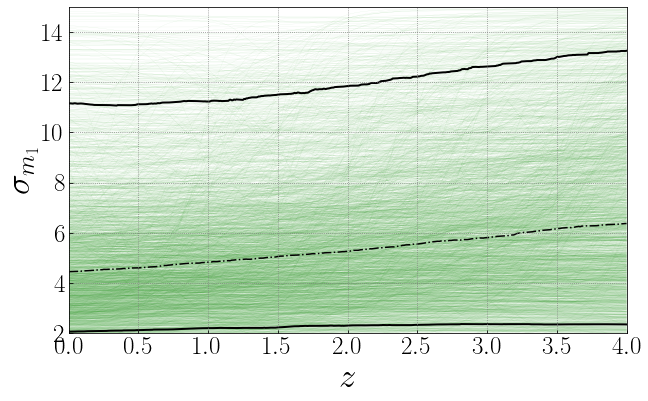

In [12]:
fig,ax = plt.subplots(figsize=(10,6))
ax.set_rasterization_zorder(2)
sig_matrix = np.zeros((len(range(samps.sig_m1.size)), len(zs)))
for i in range(samps.sig_m1.size):
    sig_r = sigmoid_no_delta(samps.sig_m1.values[i],
                               samps.high_sig.values[i],
                               10.**samps.log_width_sig.values[i],
                               samps.middle_z_sig.values[i],
                               zs,
                              )
    plt.plot(zs, sig_r, lw = 0.15, color='#33a02c', alpha = 0.2, zorder = 1)
    sig_matrix[i, :] = sig_r

median_sig = np.median(sig_matrix, axis = 0)
plt.xlim(0,4)
plt.ylim(2,15)
ax.set_xlabel(r"$z$", fontsize = 35)
ax.set_ylabel(r"$\sigma_{m_1}$", fontsize = 35)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.plot(zs, median_sig, "-.", c="k", zorder = 1)
plt.plot(zs,np.quantile(sig_matrix,0.05,axis=0), zorder = 1, color='k', lw=2, alpha=1)
plt.plot(zs,np.quantile(sig_matrix,0.95,axis=0), zorder = 1, color='k', lw=2, alpha=1)
plt.savefig("Trace_sigma_peak.pdf", dpi=400, bbox_inches='tight')
plt.show()